In [1]:
from PIL import Image
import glob

def image_grid(imgs, rows, cols, resize=256):
    assert len(imgs) == rows * cols

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]

    w, h = imgs[0].size
    grid_w, grid_h = cols * w, rows * h
    grid = Image.new("RGB", size=(grid_w, grid_h))

    for i, img in enumerate(imgs):
        x = i % cols * w
        y = i // cols * h
        grid.paste(img, box=(x, y))

    return grid

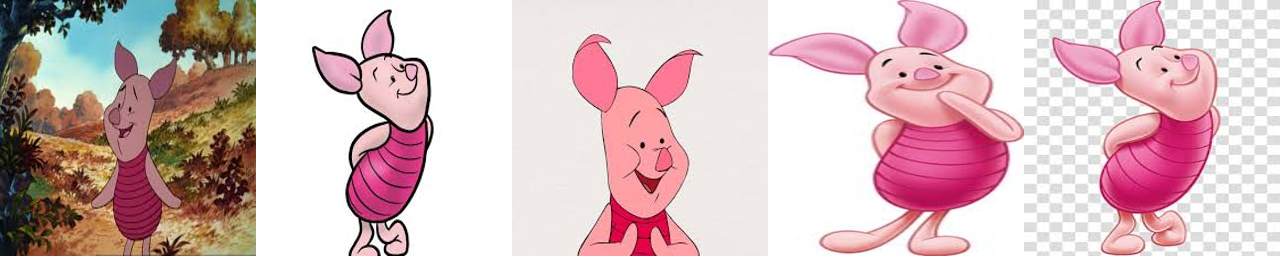

In [2]:
# imgs = [Image.open(path) for path in glob.glob("/content/drive/MyDrive/Thesis/data/*.jpg")]

imgs = [Image.open(path) for path in glob.glob("/Users/maelys/Desktop/BSE/Thesis/Comics-GenAI/data/*.jpg")]
num_imgs_to_preview = min(5, len(imgs))

# Display the images in a grid
image_grid(imgs[:num_imgs_to_preview], 1, num_imgs_to_preview) #.show()

In [5]:
# !autotrain dreambooth \
# --model "stabilityai/stable-diffusion-xl-base-1.0" \
# --project-name "Dreambooth-SDXL" \
# --image-path "/content/drive/MyDrive/Thesis/data" \
# --prompt "A photo of Piglet." \
# --resolution 1024 \
# --batch-size 1 \
# --num-steps 500 \
# --gradient-accumulation 4 \ ###
# --lr 1e-4 \
# --mixed-precision 'fp16'

goal is to use mixed-precision 'fp16' with gpus

In [6]:
!autotrain dreambooth \
--model "stabilityai/stable-diffusion-xl-base-1.0" \
--project-name "Dreambooth-SDXL" \
--image-path "/Users/maelys/Desktop/BSE/Thesis/Comics-GenAI/data/" \
--prompt "An image of Piglet" \
--resolution 1024 \
--batch-size 1 \
--num-steps 500 \
--lr 1e-4 \
--mixed-precision 'no' \
--push-to-hub \
--token "" \
--repo-id "maelysjb/sdxl-lora-piglet"

> INFO    Namespace(version=False, revision=None, tokenizer=None, image_path='/Users/maelys/Desktop/BSE/Thesis/Comics-GenAI/data/', class_image_path=None, prompt='An image of Piglet', class_prompt=None, num_class_images=100, class_labels_conditioning=None, prior_preservation=None, prior_loss_weight=1.0, resolution=1024, center_crop=None, train_text_encoder=None, sample_batch_size=4, num_steps=500, checkpointing_steps=100000, resume_from_checkpoint=None, scale_lr=None, scheduler='constant', warmup_steps=0, num_cycles=1, lr_power=1.0, dataloader_num_workers=0, use_8bit_adam=None, adam_beta1=0.9, adam_beta2=0.999, adam_weight_decay=0.01, adam_epsilon=1e-08, max_grad_norm=1.0, allow_tf32=None, prior_generation_precision=None, local_rank=-1, xformers=None, pre_compute_text_embeddings=None, tokenizer_max_length=None, text_encoder_use_attention_mask=None, rank=4, xl=None, mixed_precision='no', validation_prompt=None, num_validation_images=4, validation_epochs=50, checkpoints_total_limit=None,

goal is to use variant fp16

In [3]:
from diffusers import DiffusionPipeline, AutoencoderKL, StableDiffusionXLImg2ImgPipeline
import torch

vae = AutoencoderKL.from_pretrained(
    "madebyollin/sdxl-vae-fp16-fix",
    # torch_dtype=torch.float16
)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    # torch_dtype=torch.float16,
    # variant="fp16",
    use_safetensors=True,
)

# pipe.to("cpu");
pipe.load_lora_weights("maelysjb/sdxl-lora-piglet", weight_name="pytorch_lora_weights.safetensors", token="")

# RuntimeError: Expected one of cpu, cuda, ipu, xpu, mkldnn, opengl, opencl, ideep, hip, ve, fpga, ort, xla, lazy, vulkan, mps, meta, hpu, mtia, privateuseone device type at start of device string: metal

/Users/maelys/miniforge3/envs/autotrain/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/maelys/miniforge3/envs/autotrain/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/Users/maelys/miniforge3/envs/autotrain/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  6.45it/s]
/Users/maelys/miniforge3/envs/autotrain/lib/python3.10/site-packages/bitsandbytes/cextension.py:

'NoneType' object has no attribute 'cadam32bit_grad_fp32'


* prompt = "An image of Piglet running."
* prompt = "An image of Piglet waking up."

In [4]:
prompt = "An image of Piglet in the jungle."

# image = pipe(prompt=prompt, num_inference_steps=25, num_images_per_prompt = 3)
image = pipe(prompt=prompt, num_inference_steps=1, num_images_per_prompt = 1)

100%|██████████| 1/1 [01:21<00:00, 81.95s/it]


In [ ]:
image_grid(image.images, 1, 1)